In [ ]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm, trange
from tensorboardX import SummaryWriter
from torch.utils.data.sampler import SubsetRandomSampler


: 

In [ ]:
epoch = 100
batchsize = 2048
lr = 1e-4
numworker =24
validation_split = .2

In [ ]:
df = pd.read_csv("../data/predict_dataset.csv")
date = df["date"]
symbols = df["symbol"]
date, symbols = list(set(date)), list(set(symbols))
for days in tqdm(date):
    for symbol in symbols:
        day = df["date"] == days
        sym = df["symbol"] == symbol
        day_data = df[day & sym]
        print(df[sym])
    break


  0%|          | 0/571 [00:00<?, ?it/s]

      symbol        date                                            content  \
20      AMZN  2022-11-05         15 Largest Supermarket Chains in The World   
21      AMZN  2022-11-05  Opinion: A switch to ‘premium’ can keep you in...   
22      AMZN  2022-11-05  Can Google Shopping Rival Amazon? (GOOG) (GOOG...   
23      AMZN  2022-11-05      Should investors buy the dip on Amazon stock?   
24      AMZN  2022-11-05        12 Most Popular Ketchup Brands In The World   
...      ...         ...                                                ...   
25238   AMZN  2021-01-21  The Difference Between Chaikin Money Flow (CMF...   
25239   AMZN  2021-01-21  Amazon Offers To Help Biden With Covid Vaccine...   
25256   AMZN  2021-01-21  How To Tap Biden’s Stimulus Plan For 6%+ Divid...   
25257   AMZN  2021-01-21             Why XRP Is Outperforming Bitcoin Today   
25258   AMZN  2021-01-21  Future Group Stocks Rise As Exchanges Clear De...   

           match  sentiment      score  pre2dreturn

In [ ]:
class Stock(Dataset):
    def __init__(self, df, news_max = 20) -> None:
        features, prices, values = [], [], []
        
        date = df["date"]
        symbols = df["symbol"]
        date, symbols = list(set(date)), list(set(symbols))
        for days in tqdm(date):
            for symbol in symbols:
                day = df["date"] == days
                sym = df["symbol"] == symbol
                day_data = df[day & sym]
                news_num = len(day_data)
                if news_num == 0: continue
                feature = pd.concat([day_data[f"f{idx+1:02d}"] 
                                        for idx in range(16)], axis=1).to_numpy()
                price = [day_data[f"pre{idx}dreturn"].to_numpy() for idx in range(2, -1, -1)]
                price = np.concatenate([price], axis=0)[:,0]
                value = day_data["nextreturn"].to_numpy()[0]
                if news_num > news_max:
                    choice = np.random.choice(news_num, news_max, replace=False)
                    feature, news_num = feature[choice], news_max
                feature = np.pad(feature, [(0, news_max - news_num), (0, 0)])
                features.append(feature)
                prices.append(price)
                values.append(value)
        self.len = len(features)
        self.features, self.prices, self.values = features, prices, values
        
    def __getitem__(self, idx):
        return self.features[idx], self.prices[idx], self.values[idx]

    def __len__(self):
        return self.len

In [5]:
merge = pd.read_csv("../data/predict_dataset.csv")
dataset = Stock(merge)
np.random.seed(42)
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
np.random.shuffle(indices)
indices = {
    "train" : indices[split:],
    "valid" : indices[:split]
}
sampler = {x : SubsetRandomSampler(indices[x]) for x in ["train", "valid"]}
loader = {x : DataLoader(dataset, batch_size=batchsize, sampler=sampler[x]) for x in ["train", "valid"]}

100%|██████████| 571/571 [00:09<00:00, 60.86it/s]


In [19]:
class predict(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_down = nn.Sequential(
                                nn.Linear(320, 32),
                                nn.ReLU(),
                                nn.Linear(32, 3),
                                nn.ReLU()
                            )
        self.predict = nn.Linear(6, 1)
        self.relu = nn.ReLU()
    def forward(self, news, price):
        news = torch.flatten(news, start_dim=1).to(torch.float32)
        price = torch.flatten(price, start_dim=1).to(torch.float32)
        news = self.feature_down(news)
        x = torch.cat((news, price), 1)
        x = self.relu(self.predict(x))
        out = torch.flatten(x)
        return out

In [20]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
device = torch.device(device)
mymodel = predict()
mymodel = mymodel.to(device)

In [21]:
optimizer = optim.SGD(mymodel.parameters(), lr=1e-4, momentum=0.99)
lr_schedule = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

In [26]:
min_loss = 1e4
criterion = F.mse_loss
Dist = nn.L1Loss()
COMMENT = f"lr={lr},bz={batchsize}"
writer = SummaryWriter(comment=COMMENT)
train_loss = 1e10
for eps in trange(epoch):
    for state in ["train", "valid"]:
        if state == "train":  mymodel.train()
        else:                 mymodel.eval()
        tqdm_bar = tqdm(loader[state], leave=False)
        tqdm_bar.set_description(f"[{eps+1}/{epoch}]")  
        loss_list, dist_list = [], []
        
        for feature, price, values in tqdm_bar:
            feature = feature.to(device)
            price = price.to(device)
            values = values.to(device).to(torch.float32)
            out = mymodel(feature,price)
            loss = criterion(out,values)
            dist = Dist(out,values)
            loss_list.append(loss.item())
            dist_list.append(dist.item())

            if state == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                lr_schedule.step()
        avg_loss = np.mean(np.array(loss_list))
        avg_dist = np.mean(np.array(dist_list))
        writer.add_scalar(f"{state}/loss", avg_loss, eps)
        writer.add_scalar(f"{state}/dist", avg_dist, eps)
        if state == "train":
            train_loss = min(train_loss, avg_loss)
        
        if state == "valid" and min_loss > avg_loss:
            min_loss = avg_loss
            torch.save(mymodel.state_dict(), f"../pretrained/predict.pt")
        # print(f"epoch:{eps}, {state} loss: {avg_loss}")
        

100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


In [ ]:
out = out.detach().cpu().numpy()
values = values.detach().cpu().numpy()

Text(0, 0.5, 'return')

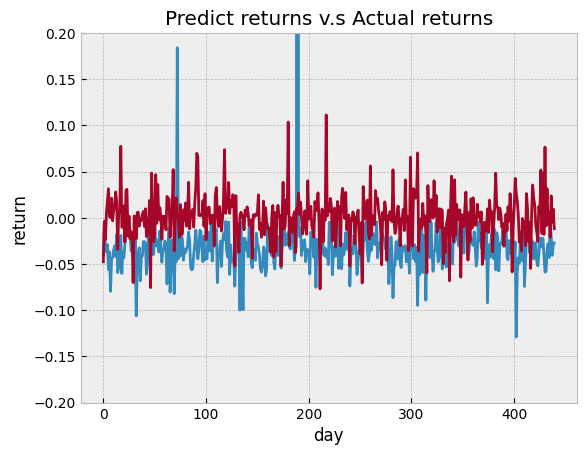

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.style.use('bmh')
fig = plt.figure()
ax = plt.axes()
plt.plot(out,"-",values,"-")
plt.ylim(-0.15, 0.2)
plt.title("Predict returns v.s Actual returns")
plt.xlabel("day")
plt.ylabel("return")